# Stock Predictions

## Imports

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)
## set pandas to display more columns
pd.set_option('display.max_columns',100)

In [2]:
spy = yf.download('SPY')

[*********************100%***********************]  1 of 1 completed


In [3]:
spy.to_csv('spy.csv')

In [4]:
df = pd.read_csv('spy.csv')

In [5]:
df.Date = pd.to_datetime(df.Date)
df.set_index('Date')

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1993-01-29,43.968750,43.968750,43.750000,43.937500,24.941395,1003200
1993-02-01,43.968750,44.250000,43.968750,44.250000,25.118790,480500
1993-02-02,44.218750,44.375000,44.125000,44.343750,25.172018,201300
1993-02-03,44.406250,44.843750,44.375000,44.812500,25.438093,529400
1993-02-04,44.968750,45.093750,44.468750,45.000000,25.544527,531500
...,...,...,...,...,...,...
2023-12-11,459.690002,462.170013,459.470001,461.989990,461.989990,65002200
2023-12-12,461.630005,464.200012,460.600006,464.100006,464.100006,68327600
2023-12-13,464.489990,470.760010,464.119995,470.500000,470.500000,93278000


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7777 entries, 0 to 7776
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       7777 non-null   datetime64[ns]
 1   Open       7777 non-null   float64       
 2   High       7777 non-null   float64       
 3   Low        7777 non-null   float64       
 4   Close      7777 non-null   float64       
 5   Adj Close  7777 non-null   float64       
 6   Volume     7777 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 425.4 KB


In [7]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,7777.000000,7777.000000,7777.000000,7777.000000,7777.000000,7.777000e+03
mean,170.098776,171.120418,168.976380,170.107732,142.250430,8.447202e+07
std,106.201045,106.774330,105.594109,106.229123,112.387179,9.238353e+07
min,43.343750,43.531250,42.812500,43.406250,24.639826,5.200000e+03
25%,105.239998,106.110001,104.379997,105.230003,70.887115,9.994300e+06
50%,132.089996,132.910004,131.100006,132.039993,93.805748,6.309050e+07
75%,210.009995,210.860001,209.240005,210.149994,181.683960,1.160107e+08
max,479.220001,479.980011,476.059998,477.709991,472.010010,8.710263e+08


## Cumulative Returns, Draw downs, etc.

In [8]:
spy = yf.download('SPY')

[*********************100%***********************]  1 of 1 completed


In [9]:
spy = spy.Close.to_frame()

In [10]:
spy['d_returns'] = np.log(spy.div(spy.shift(1)))

In [11]:
spy.dropna(inplace=True)
spy

,Close,d_returns
Date,,
1993-02-01,44.250000,0.007087
1993-02-02,44.343750,0.002116
1993-02-03,44.812500,0.010515
1993-02-04,45.000000,0.004175
1993-02-05,44.968750,-0.000695
...,...,...
2023-12-11,461.989990,0.003882
2023-12-12,464.100006,0.004557
2023-12-13,470.500000,0.013696


In [12]:
spy.d_returns.sum()

2.3698579027188664

In [13]:
np.exp(spy.d_returns.sum())

10.695872321746078

In [14]:
spy['cumm_returns'] = spy.d_returns.cumsum().apply(np.exp)
spy

,Close,d_returns,cumm_returns
Date,,,
1993-02-01,44.250000,0.007087,1.007112
1993-02-02,44.343750,0.002116,1.009246
1993-02-03,44.812500,0.010515,1.019915
1993-02-04,45.000000,0.004175,1.024182
1993-02-05,44.968750,-0.000695,1.023471
...,...,...,...
2023-12-11,461.989990,0.003882,10.514708
2023-12-12,464.100006,0.004557,10.562731
2023-12-13,470.500000,0.013696,10.708393


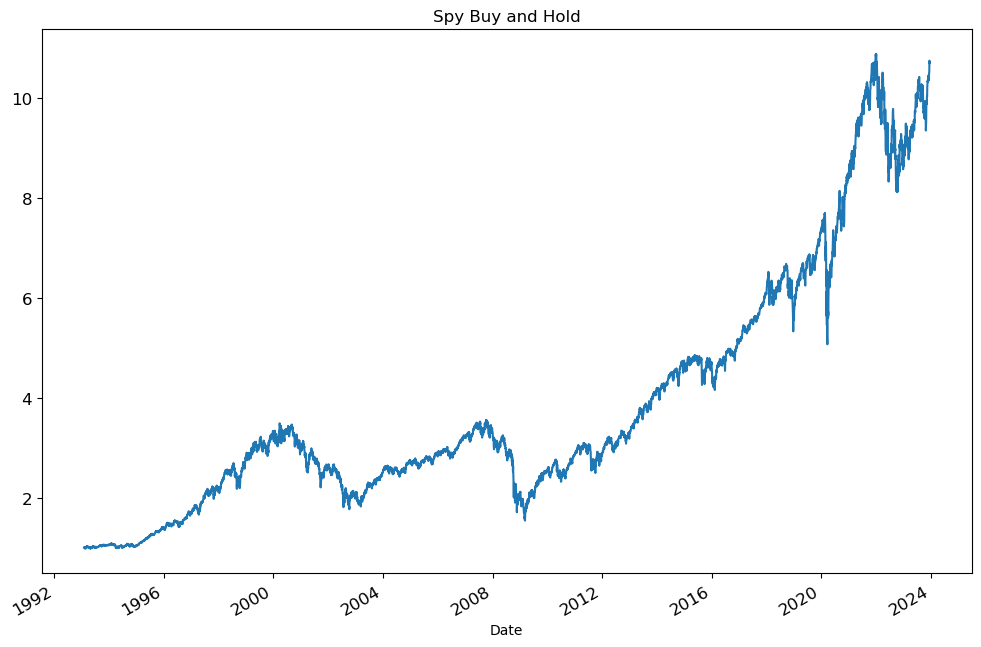

In [15]:
spy.cumm_returns.plot(figsize=(12,8), title='Spy Buy and Hold', fontsize=12)
plt.show()

In [16]:
spy.d_returns.mean()*252

0.07680095055107437

In [17]:
spy.d_returns.std()*np.sqrt(252)

0.18831941107290473

In [18]:
# Calculating draw downs (finding the peaks and valleys)
spy['cumm_max'] = spy.cumm_returns.cummax()

In [19]:
spy

,Close,d_returns,cumm_returns,cumm_max
Date,,,,
1993-02-01,44.250000,0.007087,1.007112,1.007112
1993-02-02,44.343750,0.002116,1.009246,1.009246
1993-02-03,44.812500,0.010515,1.019915,1.019915
1993-02-04,45.000000,0.004175,1.024182,1.024182
1993-02-05,44.968750,-0.000695,1.023471,1.024182
...,...,...,...,...
2023-12-11,461.989990,0.003882,10.514708,10.872489
2023-12-12,464.100006,0.004557,10.562731,10.872489
2023-12-13,470.500000,0.013696,10.708393,10.872489


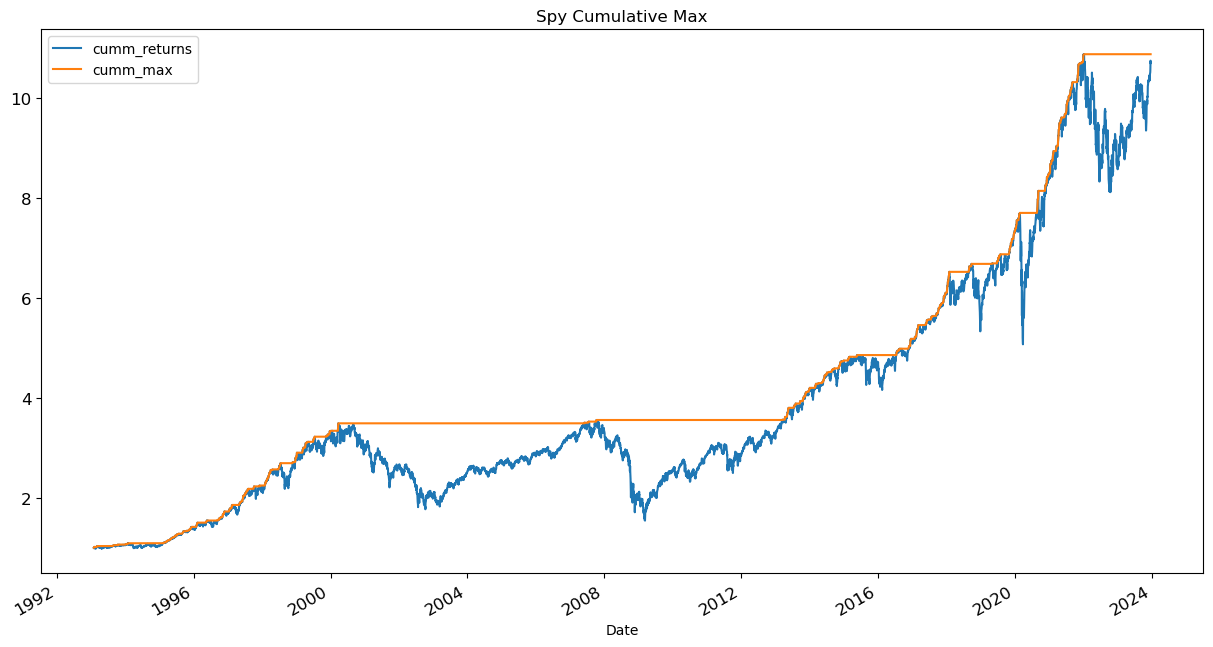

In [20]:
spy[["cumm_returns","cumm_max"]].plot(figsize=(15,8), title='Spy Cumulative Max', fontsize=12)
plt.show()

In [21]:
spy['draw_down'] = spy['cumm_max'] - spy['cumm_returns']
spy

,Close,d_returns,cumm_returns,cumm_max,draw_down
Date,,,,,
1993-02-01,44.250000,0.007087,1.007112,1.007112,0.000000
1993-02-02,44.343750,0.002116,1.009246,1.009246,0.000000
1993-02-03,44.812500,0.010515,1.019915,1.019915,0.000000
1993-02-04,45.000000,0.004175,1.024182,1.024182,0.000000
1993-02-05,44.968750,-0.000695,1.023471,1.024182,0.000711
...,...,...,...,...,...
2023-12-11,461.989990,0.003882,10.514708,10.872489,0.357781
2023-12-12,464.100006,0.004557,10.562731,10.872489,0.309758
2023-12-13,470.500000,0.013696,10.708393,10.872489,0.164097


In [22]:
spy.draw_down.max()

2.7573256078859103

In [23]:
spy.draw_down.idxmax()

Timestamp('2022-10-12 00:00:00')

In [24]:
spy.loc[(spy.index<='2022-10-12')]

,Close,d_returns,cumm_returns,cumm_max,draw_down
Date,,,,,
1993-02-01,44.250000,0.007087,1.007112,1.007112,0.000000
1993-02-02,44.343750,0.002116,1.009246,1.009246,0.000000
1993-02-03,44.812500,0.010515,1.019915,1.019915,0.000000
1993-02-04,45.000000,0.004175,1.024182,1.024182,0.000000
1993-02-05,44.968750,-0.000695,1.023471,1.024182,0.000711
...,...,...,...,...,...
2022-10-06,373.200012,-0.010369,8.493884,10.872489,2.378606
2022-10-07,362.790009,-0.028290,8.256956,10.872489,2.615533
2022-10-10,360.019989,-0.007665,8.193912,10.872489,2.678578


In [25]:
# Calculating drawdown percentage
spy['draw_down_percentage'] = (spy['cumm_max'] - spy['cumm_returns']) / spy['cumm_max']
spy

,Close,d_returns,cumm_returns,cumm_max,draw_down,draw_down_percentage
Date,,,,,,
1993-02-01,44.250000,0.007087,1.007112,1.007112,0.000000,0.000000
1993-02-02,44.343750,0.002116,1.009246,1.009246,0.000000,0.000000
1993-02-03,44.812500,0.010515,1.019915,1.019915,0.000000,0.000000
1993-02-04,45.000000,0.004175,1.024182,1.024182,0.000000,0.000000
1993-02-05,44.968750,-0.000695,1.023471,1.024182,0.000711,0.000694
...,...,...,...,...,...,...
2023-12-11,461.989990,0.003882,10.514708,10.872489,0.357781,0.032907
2023-12-12,464.100006,0.004557,10.562731,10.872489,0.309758,0.028490
2023-12-13,470.500000,0.013696,10.708393,10.872489,0.164097,0.015093


In [26]:
# Finding the max drawdown
spy.draw_down_percentage.max()

0.5647366917817166

In [27]:
spy.draw_down_percentage.idxmax()

Timestamp('2009-03-09 00:00:00')

In [28]:
spy.loc[(spy.index<='2009-03-09')]

,Close,d_returns,cumm_returns,cumm_max,draw_down,draw_down_percentage
Date,,,,,,
1993-02-01,44.250000,0.007087,1.007112,1.007112,0.000000,0.000000
1993-02-02,44.343750,0.002116,1.009246,1.009246,0.000000,0.000000
1993-02-03,44.812500,0.010515,1.019915,1.019915,0.000000,0.000000
1993-02-04,45.000000,0.004175,1.024182,1.024182,0.000000,0.000000
1993-02-05,44.968750,-0.000695,1.023471,1.024182,0.000711,0.000694
...,...,...,...,...,...,...
2009-03-03,70.070000,-0.007535,1.594765,3.561422,1.966657,0.552211
2009-03-04,71.730003,0.023414,1.632546,3.561422,1.928876,0.541603
2009-03-05,68.800003,-0.041705,1.565861,3.561422,1.995562,0.560327


## SMA Strategy (SPY)

In [29]:
data = spy.Close.loc[(spy.index>='1991-01-01')]
data = data.to_frame()
data

,Close
Date,
1993-02-01,44.250000
1993-02-02,44.343750
1993-02-03,44.812500
1993-02-04,45.000000
1993-02-05,44.968750
...,...
2023-12-11,461.989990
2023-12-12,464.100006
2023-12-13,470.500000


In [30]:
# moving averages
sma_s = 50
sma_l = 100

data['sma_s'] = data.Close.rolling(sma_s).mean()
data['sma_l'] = data.Close.rolling(sma_l).mean()

In [31]:
data

,Close,sma_s,sma_l
Date,,,
1993-02-01,44.250000,NaN,NaN
1993-02-02,44.343750,NaN,NaN
1993-02-03,44.812500,NaN,NaN
1993-02-04,45.000000,NaN,NaN
1993-02-05,44.968750,NaN,NaN
...,...,...,...
2023-12-11,461.989990,438.447000,441.386501
2023-12-12,464.100006,439.182800,441.505701
2023-12-13,470.500000,440.161000,441.668701


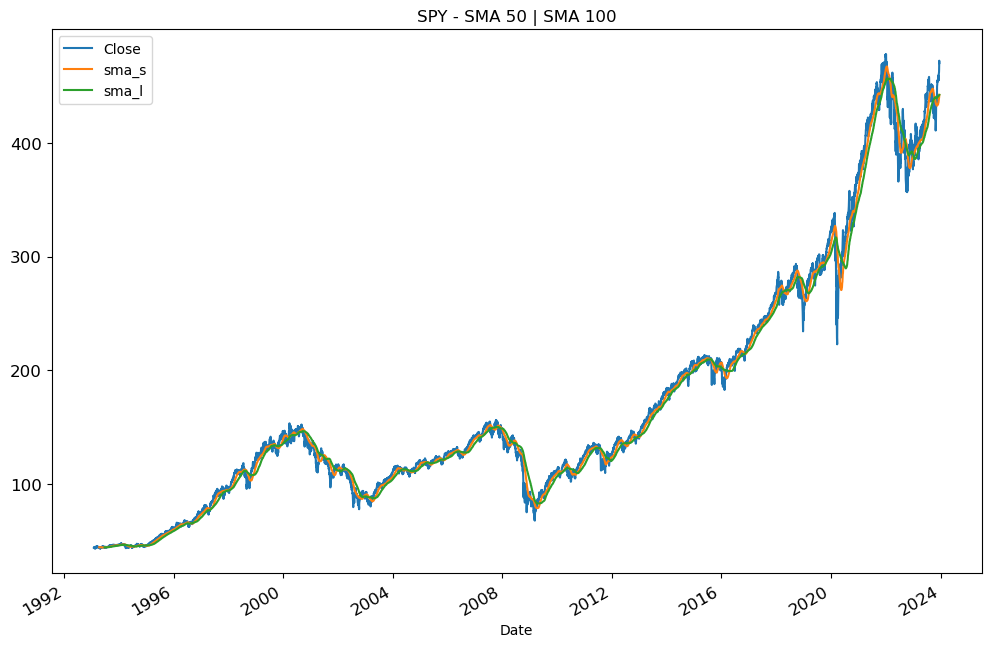

In [32]:
data.plot(figsize=(12,8), title='SPY - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12);

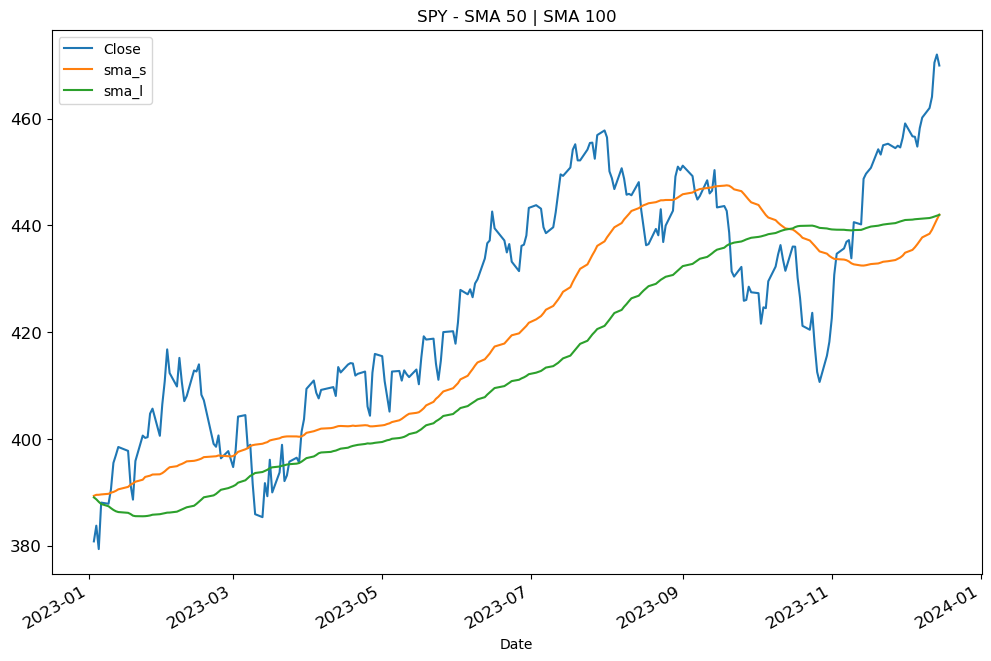

In [33]:
data.loc['2023'].plot(figsize=(12,8), title='SPY - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12);

In [34]:
data.dropna(inplace=True)

In [35]:
data['position'] = np.where(data['sma_s']>data['sma_l'], 1, -1)

In [36]:
data

,Close,sma_s,sma_l,position
Date,,,,
1993-06-23,44.218750,44.668125,44.688437,-1
1993-06-24,44.812500,44.665625,44.694063,-1
1993-06-25,44.781250,44.662500,44.698437,-1
1993-06-28,45.281250,44.669375,44.703125,-1
1993-06-29,45.062500,44.675625,44.703750,-1
...,...,...,...,...
2023-12-11,461.989990,438.447000,441.386501,-1
2023-12-12,464.100006,439.182800,441.505701,-1
2023-12-13,470.500000,440.161000,441.668701,-1


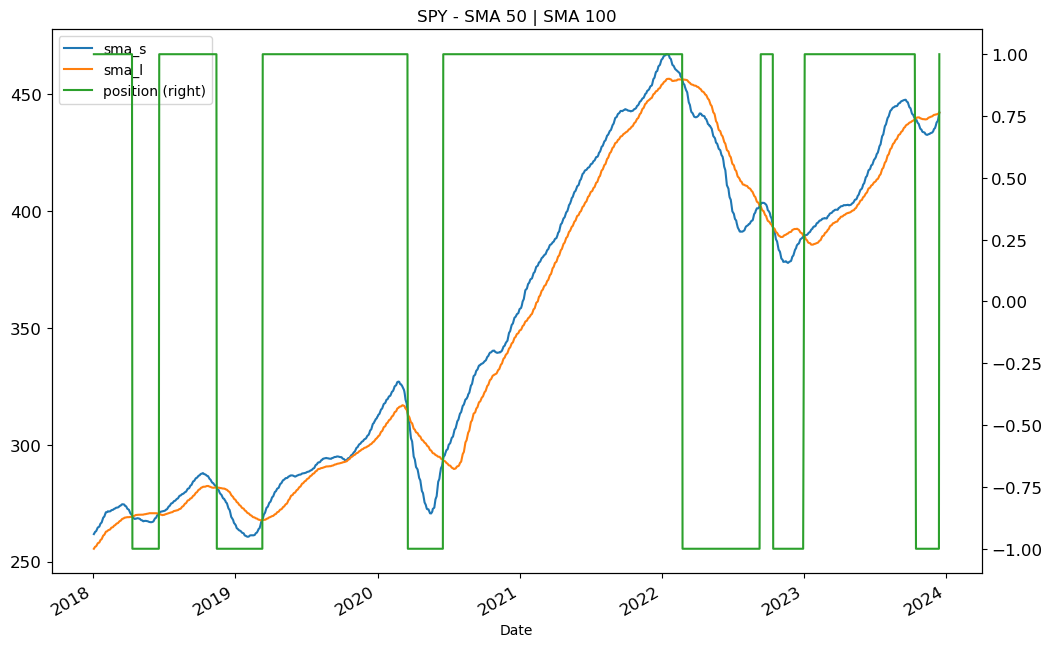

In [37]:
data.loc['2018':'2023',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='SPY - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,
                                              secondary_y='position');

In [38]:
# buy and hold column
data['returns_bnh'] = np.log(data.Close.div(data.Close.shift(1)))

In [39]:
# strategy column
data['strategy'] = data['returns_bnh'] * data.position.shift(1)

In [40]:
data.dropna(inplace=True)

In [41]:
data[['returns_bnh','strategy']].sum()

returns_bnh    2.363477
strategy       0.858484
dtype: float64

In [42]:
data[['returns_bnh','strategy']].sum().apply(np.exp)

returns_bnh    10.627842
strategy        2.359581
dtype: float64

In [43]:
data[['returns_bnh','strategy']].std()*np.sqrt(252) # annual std

returns_bnh    0.189106
strategy       0.189161
dtype: float64

### Strategy adjusted with long bias

In [44]:
data['position2'] = np.where(data['sma_s']>data['sma_l'], 1, 0)

In [45]:
data['strategy2'] = data['returns_bnh'] * data.position2.shift(1)

In [46]:
data.dropna(inplace=True)

In [47]:
data[['returns_bnh','strategy2']].sum()

returns_bnh    2.350139
strategy2      1.610981
dtype: float64

In [48]:
data[['returns_bnh','strategy2']].sum().apply(np.exp)

returns_bnh    10.487027
strategy2       5.007720
dtype: float64

In [49]:
data[['returns_bnh','strategy2']].std()*np.sqrt(252) # risk

returns_bnh    0.189104
strategy2      0.130892
dtype: float64

In [50]:
data[['strategy','strategy2']].std()*np.sqrt(252) # risk

strategy     0.189157
strategy2    0.130892
dtype: float64

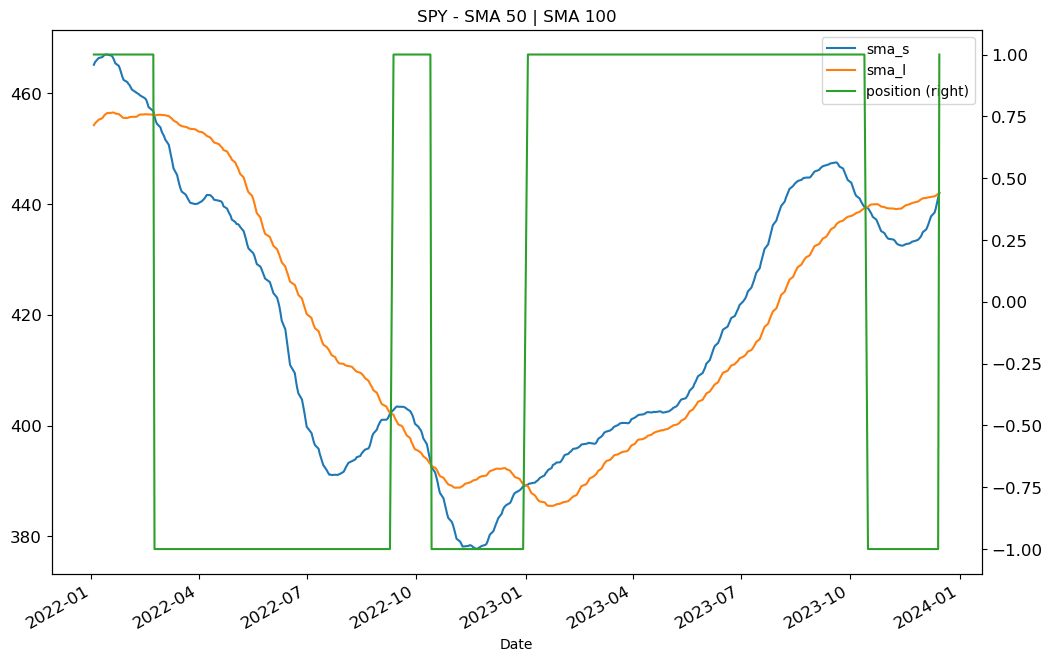

In [51]:
data.loc['2022':'2023',["sma_s", "sma_l",'position']].plot(figsize=(12,8), title='SPY - SMA {} | SMA {}'.format(sma_s, sma_l), fontsize=12,
                                              secondary_y='position');

## Custom Functions

In [ ]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [ ]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [ ]:
def plot_coeffs(coeffs, top_n=None,  figsize=(4,5), intercept=False, 
                annotate=False, ha='left',va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    """Plots the top_n coefficients from a Series, with optional annotations."""
    if (intercept==False) & ('intercept' in coeffs.index):
        coeffs = coeffs.drop('intercept')
    if top_n==None:
        ## sort all features and set title
        plot_vals = coeffs#.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        ## sort features and keep top_n and set title
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
           ylabel='Feature Names', 
           title=title)
    ax.axvline(0, color='k')
    
    if annotate==True:
        annotate_hbars(ax, ha=ha,va=va,size=size,xytext=xytext,
                       textcoords=textcoords)
    ## return ax in case want to continue to update/modify figure
    return ax

def annotate_hbars(ax, ha='left',va='center',size=12,  xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height()/2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha,va=va,size=size,
                        xytext=xytext, textcoords=textcoords)

In [ ]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances

In [ ]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")

In [ ]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [ ]:
def plot_importance_color_ax(importances, top_n=None,  figsize=(8,6), 
                          color_dict=None, ax=None):
    
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors, ax=ax)
        
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize, ax=ax)
        
    # set titles and axis labels
    ax.set(xlabel='Importance', 
           ylabel='Feature Names', 
           title=title)
    
    ## return ax in case want to continue to update/modify figure
    return ax

In [ ]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',
                    top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [ ]:
def get_coeffs_linreg(lin_reg, feature_names = None, sort=True,ascending=True,
                     name='LinearRegression Coefficients'):
    if feature_names is None:
        feature_names = lin_reg.feature_names_in_
    ## Saving the coefficients
    coeffs = pd.Series(lin_reg.coef_, index= feature_names)
    coeffs['intercept'] = lin_reg.intercept_
    if sort==True:
        coeffs = coeffs.sort_values(ascending=ascending)
    return coeffs

## Perform Train/Test Split

In [ ]:
y = spy['Close'].copy()
X = spy.drop(columns=['Close'])

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head()

In [ ]:
num_sel = make_column_selector(dtype_include='number')

In [ ]:
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

In [ ]:
preprocessor = make_column_transformer((num_pipe, num_sel), verbose_feature_names_out=False)

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                         columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                        columns = feature_names, index = X_test.index)
X_test_df.head(3)

In [ ]:
y_test.head(3)

In [ ]:
# fitting a linear regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_df, y_train)
evaluate_regression(lin_reg, X_train_df, y_train, X_test_df, y_test)

In [ ]:
coeffs = get_coeffs_linreg(lin_reg)
coeffs

In [ ]:
plot_coeffs(coeffs, top_n=3,annotate=True);

## Random Forest

In [ ]:
reg = RandomForestRegressor(random_state=SEED)
reg.fit(X_train_df, y_train)
evaluate_regression(reg, X_train_df, y_train, X_test_df, y_test)

In [ ]:
importances = pd.Series(reg.feature_importances_, index= feature_names,
                       name='Feature Importance')
importances

In [ ]:
## Saving the feature importances sorted from largest to smallest (ascending=False)
sorted_importance = importances.sort_values(ascending=False)
sorted_importance

In [ ]:
## just keep the top 5 importances and plot
sorted_importance.head(5).plot(kind='barh',
                                   figsize=(8,6));

In [ ]:
corr = df.corr()